In [47]:
import numpy as np
from PIL import Image
import matplotlib as plt
from io import BytesIO
from math import log10, sqrt

In [48]:
def load_and_scale_images(image_path, watermark_path):
    image = Image.open(image_path).convert('L')  
    image = image.resize((512, 512))
    
    image_array = np.array(image)
    
    watermark = Image.open(watermark_path).convert('L')
    watermark = watermark.resize((32, 32))
    watermark_array = np.array(watermark) > 128
    watermark = Image.fromarray(watermark_array)
    
    return image_array, watermark_array, image, watermark

In [49]:
image_array,watermark_array,input_image, watermark_image=load_and_scale_images('lena.png','watermark_image.webp')

In [50]:
def shuffle_watermark_image(watermark_image):
    np.random.seed(42)

    wm_img_array = np.array(watermark_image) 
    shape = wm_img_array.shape

    wm_img_array = wm_img_array.flatten()

    indices = np.arange(wm_img_array.size)
    i_n = np.random.permutation(indices)

    shuffled_img_array = wm_img_array[i_n]

    shuffled_image_array = shuffled_img_array.reshape(shape)
    shuffled_image = Image.fromarray(shuffled_image_array)

    return shuffled_image, i_n

In [51]:
def unshuffle_watermark_image(shuffled_image, indices, seed=42):
    np.random.seed(seed)

    shuffled_img_array = np.array(shuffled_image) 
    shape = shuffled_img_array.shape

    shuffled_img_array_flat = shuffled_img_array.flatten()

    original_img_array = np.zeros_like(shuffled_img_array_flat)

    inverse_indices = np.argsort(indices)

    
    original_img_array = shuffled_img_array_flat[inverse_indices]

    original_image_array = original_img_array.reshape(shape)
    original_image = Image.fromarray(original_image_array)

    return original_image

In [52]:
shuffled_watermark, indices = shuffle_watermark_image(watermark_image)

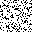

In [53]:
shuffled_watermark

In [54]:
def split_image_into_four(image):

    width, height = image.size

    mid_width = width // 2
    mid_height = height // 2

    ftl = image.crop((0, 0, mid_width, mid_height))  
    ftr = image.crop((mid_width, 0, width, mid_height))  
    fbl = image.crop((0, mid_height, mid_width, height)) 
    fbr = image.crop((mid_width, mid_height, width, height))

    return ftl, ftr, fbl, fbr

In [55]:
def merge_image_from_four(ftl, ftr, fbl, fbr):
    width, height = ftl.size
    
    merged_image = Image.new('L', (width * 2, height * 2))

    merged_image.paste(ftl, (0, 0))  
    merged_image.paste(ftr, (width, 0)) 
    merged_image.paste(fbl, (0, height))  
    merged_image.paste(fbr, (width, height))

    return merged_image

In [56]:
import bisect

def find_interval(sorted_array, x):
    index = bisect.bisect_right(sorted_array, x)
    #if index == len(sorted_array):
     #   return len(sorted_array) - 1
    return index

In [57]:
def reconstruct_image(blocks, original_indices, block_size):
    reconstruct_image = np.zeros((512 // 2, 512 // 2))
    for (U, D, Vt), (i,j) in zip(blocks, original_indices):
        #print(D[0])
        D_matrix = np.diag(D)
        r_b = np.dot(U, np.dot(D_matrix, Vt))
        reconstruct_image[i:i+block_size,j: j+block_size] = r_b
    return reconstruct_image

In [58]:
d_large = []
d_new = []
blocks = []
def watermark_embedding_in_d_matrix(ftl, wm, block_size=8):
    global d_large, d_new, blocks
    original_indices = []
    wm_array = np.array(wm) 
    wm_array = wm_array.flatten().astype('uint64')
    ftl_arr = np.array(ftl)
    #d_large = []
    #blocks = []
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            d_large.append(D[0])
            original_indices.append((i,j))
            blocks.append((U, D, V))

    T=60
    d_max = max(d_large)
    d_min = min(d_large)
    ds = np.linspace(d_min-T, d_max + T)

    #print(d_low)
    #print(d_high)
    bit_idx = 0
    for d in d_large:
        idx = find_interval(ds, d)
        dlow = ds[idx-1]
        dhigh = ds[idx]
        #print(f'Watermark bit {wm_array[bit_idx]}')
        #print(f'Donja granica {dlow}')
        #print(f'Gornja granica {dhigh}')
        #print(f'Singularna vrednosti{d}')
        
        if wm_array[bit_idx] == 1:
            blocks[bit_idx][1][0] = (dlow + (dhigh + dlow)/2)/2
            #print('if')
        else:
            blocks[bit_idx][1][0] = (dhigh + (dhigh + dlow)/2)/2
            #print('else')
        d_new.append(blocks[bit_idx][1][0])
        bit_idx += 1
        #print('-------------------')

    result = reconstruct_image(blocks, original_indices, 8)
    return result

In [59]:
def watermark_embedding_in_u_matrix(fbr, wm, block_size=8, alpha=0.0):
    fbr_arr = np.array(fbr)
    wm_array = np.array(wm).flatten().astype('uint64')

    original_indices = []
    blocks = []
    
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            original_indices.append((i,j))
            blocks.append((U, D, V))

    bit_idx = 0
    for U, D, V in blocks:
        u_diff = abs(U[0, 0]) - abs(U[1, 0])
        
        if (wm_array[bit_idx] == 1 and u_diff > alpha) or (wm_array[bit_idx]==0 and u_diff<alpha):
            #print('1')
            U[1,0]=-abs(abs(U[1,0])-(alpha-u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha-u_diff)/2)
        elif (wm_array[bit_idx] == 1 and u_diff < alpha) or (wm_array[bit_idx]==0 and u_diff>alpha):
            U[1,0]=-abs(abs(U[1,0])-(alpha+u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha+u_diff)/2)
            #print('2')
        bit_idx += 1

    reconstructed_fbr = reconstruct_image(blocks, original_indices, block_size)
    return reconstructed_fbr

In [60]:
def watermak_embedding(image, wm):
    ftl, ftr, fbl, fbr = split_image_into_four(input_image)
    
    ftl_new = watermark_embedding_in_d_matrix(ftl, wm)
    ftl_new = Image.fromarray(ftl_new)
    ftl_new.show()
    
    fbr_new = watermark_embedding_in_u_matrix(fbr, wm)
    fbr_new = Image.fromarray(fbr_new)
    fbr_new.show()
    
    merged_image = merge_image_from_four(ftl_new, ftr, fbl, fbr_new)
    merged_image.show()
    merged_image.save('watermarked_image.png')
    
    return merged_image

In [61]:
watermarked_image = watermak_embedding(input_image, shuffled_watermark)

In [62]:
ftl_new, _, _, fbr_new = split_image_into_four(watermarked_image)

In [63]:
T=60
d_max = max(d_large)
d_min = min(d_large)
ds = np.linspace(d_min-T, d_max + T)

In [64]:
def extract_watermark_from_d_matrix(ftl,watermark_size=(32, 32), block_size=8):
    
    ftl_arr = np.array(ftl)

    extraxted_watermark = []
    
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)

            d = D[0]
            #print(d)
            idx = find_interval(ds, d)
            dh = ds[idx]
            dl = ds[idx-1]
            #print(f'dhigh {dh}')
            #print(f'dlow {dl}')
            #print('-----------')

            if  d < ((dl+dh)/2):
                extraxted_watermark.append(1)
                #print('if')
            else:
                extraxted_watermark.append(0)
                #print('else')
    extraxted_watermark_result = np.array(extraxted_watermark).reshape((32,32))
    return extraxted_watermark_result

In [65]:
res = extract_watermark_from_d_matrix(ftl_new)

In [66]:
res

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1]])

In [67]:
watermark1_extracted = Image.fromarray(res.astype(np.uint8)*255)

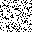

In [68]:
watermark1_extracted

In [69]:
original_watermark1_extracted = unshuffle_watermark_image(watermark1_extracted, indices)

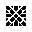

In [70]:
original_watermark1_extracted

In [71]:
def extract_watermark_from_u_matrix(fbr, watermark_size=(32, 32), block_size=8):
    fbr_arr = np.array(fbr)
    extracted_watermark = []
    
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)

            if abs(U[0,0])>abs(U[1,0]):
                extracted_watermark.append(0)
            else:
                extracted_watermark.append(1)
    
    extracted_watermark = np.array(extracted_watermark).reshape(watermark_size)
    return extracted_watermark


In [72]:
watermark2_fbr = extract_watermark_from_u_matrix(fbr_new)

In [73]:
watermark2_fbr

array([[0, 0, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1]])

In [74]:
watermark2_extracted = Image.fromarray(watermark2_fbr.astype(np.uint8)*255)

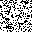

In [75]:
watermark2_extracted

In [76]:
original_watermark2_extracted = unshuffle_watermark_image(watermark2_extracted, indices)

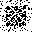

In [77]:
original_watermark2_extracted

# Testing and Transformations

In [78]:
def compress_image(image, quality):
    buffer = BytesIO()
    image.save(buffer, format="JPEG", quality=quality)
    compressed_image = Image.open(buffer)
    return compressed_image

In [79]:
def rotate_image(image, angle):
    return image.rotate(angle, expand=False)

In [80]:
def resize_and_restore_image(image, target_size=(256, 256), original_size=(512, 512)):
    scaled_down_image = image.resize(target_size, Image.BILINEAR)
    restored_image = scaled_down_image.resize(original_size, Image.BILINEAR)
    return restored_image

In [113]:
from PIL import ImageEnhance

def adjust_brightness(image, factor):
    #factor 1.2 increases brightness for 20%
    #factor 0.8 decreases brightness for 20%
    enhancer = ImageEnhance.Brightness(image)
    adjusted_image = enhancer.enhance(factor)
    return adjusted_image

In [222]:
def salt_and_pepper_noise(image, density=0.01):
    image_array = np.array(image)
    output = np.copy(image_array)

    num_salt = np.ceil(density * image_array.size * 0.5)
    num_pepper = np.ceil(density * image_array.size * 0.5)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_array.shape]
    output[tuple(coords)] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_array.shape]
    output[tuple(coords)] = 0

    return Image.fromarray(output)

### METRICS: PSNR, BER, NC

In [81]:
def psnr(original, compressed):
    original = np.array(original)
    compressed = np.array(compressed)
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # slike su identične
        return 100
    max_pixel = 255.0
    return 10 * log10(max_pixel ** 2 / mse)

In [82]:
def ber(original_watermark, extracted_watermark):
    original_watermark = np.array(original_watermark).flatten()
    extracted_watermark = np.array(extracted_watermark).flatten() > 128
    total_bits = len(original_watermark)
    error_bits = np.sum(original_watermark != extracted_watermark)
    return error_bits / total_bits

In [83]:
def nc(original_watermark, extracted_watermark):
    original_watermark = np.array(original_watermark).flatten()
    extracted_watermark = np.array(extracted_watermark).flatten()

    numerator = np.sum(original_watermark * extracted_watermark)
    denominator = np.sqrt(np.sum(original_watermark ** 2) * np.sum(extracted_watermark ** 2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

In [84]:
def normalize_watermark(watermark):
    watermark = np.array(watermark)
    max_val = np.max(watermark)
    min_val = np.min(watermark)
    
    if max_val - min_val == 0:
        return watermark  # Ako su sve vrednosti iste
    
    return (watermark - min_val) / (max_val - min_val)


## Evaluating watermarking

In [85]:
psnr_value_watermarking = psnr(input_image, watermarked_image)

In [86]:
original_watermark1_extracted_normalized = normalize_watermark(original_watermark1_extracted)
original_watermark2_extracted_normalized = normalize_watermark(original_watermark2_extracted)

In [87]:
nc_value1 = nc(watermark_image, original_watermark1_extracted_normalized)
nc_value2 = nc(watermark_image, original_watermark2_extracted_normalized)

ber_value1 = ber(watermark_image, original_watermark1_extracted)
ber_value2 = ber(watermark_image, original_watermark2_extracted)

## Compression

In [88]:
compressed_image = compress_image(watermarked_image, 70)

In [95]:
compressed_image.size

(512, 512)

In [90]:
psnr_value_compress = psnr(input_image, compressed_image)

In [91]:
ftl_compress, _, _ ,fbr_compress = split_image_into_four(compressed_image)

watermark1_extracted_compress = extract_watermark_from_d_matrix(ftl_compress)
watermark1_extracted_compress = Image.fromarray(watermark1_extracted_compress.astype(np.uint8)*255)
watermark1_extracted_compress_original = unshuffle_watermark_image(watermark1_extracted_compress, indices)

watermark2_extracted_compress = extract_watermark_from_u_matrix(fbr_compress)
watermark2_extracted_compress = Image.fromarray(watermark2_extracted_compress.astype(np.uint8)*255)
watermark2_extracted_compress_original = unshuffle_watermark_image(watermark2_extracted_compress, indices)

ber1_value_compression = ber(watermark_image, watermark1_extracted_compress_original)
ber2_value_compression = ber(watermark_image, watermark2_extracted_compress_original)

normalized_watermark1 = normalize_watermark(watermark1_extracted_compress_original)
normalized_watermark2 = normalize_watermark(watermark2_extracted_compress_original)

nc1_value_compression = nc(watermark_image, normalized_watermark1)
nc2_value_compression = nc(watermark_image, normalized_watermark2)

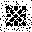

In [92]:
watermark1_extracted_compress_original

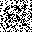

In [93]:
watermark2_extracted_compress_original

In [419]:
print(f'PSNR after watermarking {psnr_value_watermarking}')
print(f'BER1 {ber_value1}')
print(f'BER2 {ber_value2}')
print(f'NC1 {nc_value1}')
print(f'NC2 {nc_value2}')

print()

print(f'PSNR after watermarking and compresson: {psnr_value_compress}')
print(f'BER after compression and extraction from D matrixn {ber1_value_compression}')
print(f'BER after compression and extraction from U matrix {ber2_value_compression}')
print(f'NC after compression and extraction from D matrix {nc1_value_compression}')
print(f'NC after compression and extraction from U matrix {nc2_value_compression}')


PSNR after watermarking 47.81901275555902
BER1 0.0
BER2 0.15625
NC1 1.0
NC2 0.8918186632416427

PSNR after watermarking and compresson: 37.46426574963655
BER after compression and extraction from D matrixn 0.107421875
BER after compression and extraction from U matrix 0.3505859375
NC after compression and extraction from D matrix 0.9261481919632786
NC after compression and extraction from U matrix 0.7470557317774703


## PSNR (Peak Signal-to-Noise Ratio)
- **PSNR after watermarking**: 47.82 dB
  - Indicates very high image quality with minimal visual distortion due to watermarking.
- **PSNR after watermarking and compression**: 37.46 dB
  - The image quality is still acceptable after compression, though there is some degradation.

## BER (Bit Error Rate)
- **BER1 after watermarking**: 0.0
  - Perfect accuracy with no errors in watermark extraction.
- **BER2 after watermarking**: 0.15625
  - 15.625% of bits were incorrectly extracted, which is acceptable but not ideal.
- **BER after compression and extraction**:
  - **From D matrix**: 0.1074
    - 10.74% of bits were incorrectly extracted, indicating good robustness against compression.
  - **From U matrix**: 0.3525
    - 35.25% of bits were incorrectly extracted, showing weaker robustness compared to the D matrix.


## NC (Normalized Cross-Correlation)
- **NC1 after watermarking**: 1.0
  - Perfect similarity between the original and extracted watermark.
- **NC2 after watermarking**: 0.8918
  - High similarity but not perfect, indicating some errors in the watermark extraction process.
- **NC after compression and extraction**:
  - **From D matrix**: 0.9261
    - High similarity between the original and extracted watermark after compression, which is excellent.
  - **From U matrix**: 0.7449
    - Good similarity but lower than for the D matrix, suggesting the need for improvement in robustness for this matrix.

## Rotation 

In [42]:
rotated_image = rotate_image(watermarked_image, 20)

In [94]:
rotated_image.size

(512, 512)

In [44]:
psnr_value_rotate = psnr(input_image, rotated_image)
psnr_value_rotate

28.1439274335748

In [45]:
ftl_rotate, _, _ ,fbr_rotate = split_image_into_four(rotated_image)

In [46]:
#watermark1_extracted_rotate = extract_watermark_from_d_matrix(ftl_rotate)
#watermark1_extracted_rotate = Image.fromarray(watermark1_extracted_rotate.astype(np.uint8)*255)
#watermark1_extracted_rotate_original = unshuffle_watermark_image(watermark1_extracted_rotate, indices)

watermark2_extracted_rotate = extract_watermark_from_u_matrix(ftl_rotate)
watermark2_extracted_rotate = Image.fromarray(watermark2_extracted_rotate.astype(np.uint8)*255)
watermark2_extracted_rotate_original = unshuffle_watermark_image(watermark2_extracted_rotate, indices)

IndexError: index 50 is out of bounds for axis 0 with size 50

In [425]:
ber1_value_rotate = ber(watermark_image, watermark1_extracted_rotate_original)
ber1_value_rotate

0.4736328125

In [426]:
ber2_value_rotate = ber(watermark_image, watermark2_extracted_rotate_original)
ber2_value_rotate

0.5234375

In [427]:
normalized_watermark1 = normalize_watermark(watermark1_extracted_rotate_original)
normalized_watermark2 = normalize_watermark(watermark2_extracted_rotate_original)

In [428]:
nc1_value_rotate = nc(watermark_image, normalized_watermark1)
nc1_value_rotate

0.6494129066014692

In [429]:
nc2_value_rotate = nc(watermark_image, normalized_watermark2)
nc2_value_rotate

0.5861995795842452

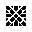

In [430]:
original_watermark1_extracted

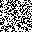

In [431]:
watermark1_extracted_rotate_original

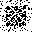

In [432]:
original_watermark2_extracted

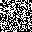

In [433]:
watermark2_extracted_rotate_original

## Resizing

In [97]:
resized_image = resize_and_restore_image(watermarked_image)

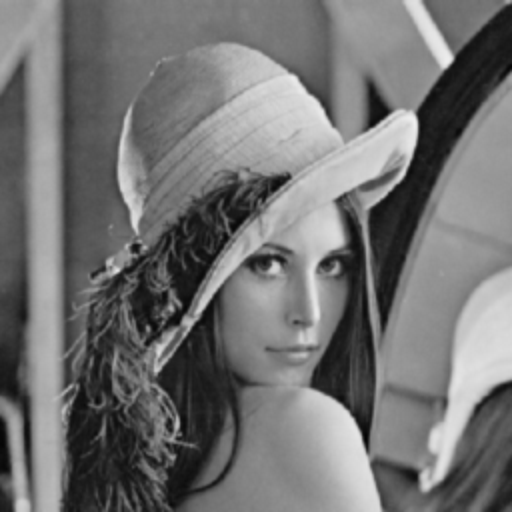

In [98]:
resized_image

In [99]:
psnr_value_resize = psnr(input_image, resized_image)
psnr_value_resize

34.34240961910524

In [100]:
ftl_resize, _, _ ,fbr_resize = split_image_into_four(resized_image)

In [101]:
watermark1_extracted_resize = extract_watermark_from_d_matrix(ftl_resize)
watermark1_extracted_resize = Image.fromarray(watermark1_extracted_resize.astype(np.uint8)*255)
watermark1_extracted_resize_original = unshuffle_watermark_image(watermark1_extracted_resize, indices)

watermark2_extracted_resize = extract_watermark_from_u_matrix(ftl_resize)
watermark2_extracted_resize = Image.fromarray(watermark2_extracted_resize.astype(np.uint8)*255)
watermark2_extracted_resize_original = unshuffle_watermark_image(watermark2_extracted_resize, indices)

In [102]:
ber1_value_resize = ber(watermark_image, watermark1_extracted_resize_original)
ber1_value_resize

0.1943359375

In [103]:
ber2_value_resize = ber(watermark_image, watermark2_extracted_resize_original)
ber2_value_resize

0.5576171875

In [104]:
normalized_watermark1_resize = normalize_watermark(watermark1_extracted_resize_original)
normalized_watermark2_resize = normalize_watermark(watermark2_extracted_resize_original)

In [105]:
nc1_value_rotate = nc(watermark_image, normalized_watermark1_resize)
nc1_value_rotate

0.8644462235857158

In [106]:
nc2_value_rotate = nc(watermark_image, normalized_watermark2_resize)
nc2_value_rotate

0.5598558701691863

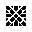

In [107]:
original_watermark1_extracted

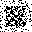

In [108]:
watermark1_extracted_resize_original

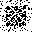

In [109]:
original_watermark2_extracted

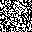

In [110]:
watermark2_extracted_resize_original

## Brigthness

In [207]:
brighted_image = adjust_brightness(watermarked_image,factor=0.98)

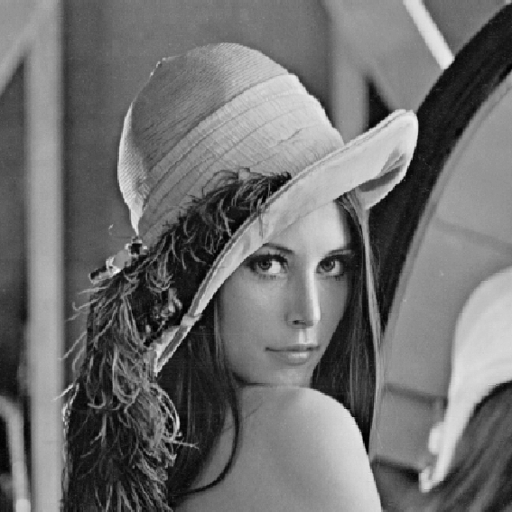

In [208]:
brighted_image

In [209]:
psnr_value_bright = psnr(input_image, brighted_image)
psnr_value_bright

37.44076377982288

In [210]:
ftl_bright, _, _ ,fbr_bright = split_image_into_four(brighted_image)

In [211]:
watermark1_extracted_bright = extract_watermark_from_d_matrix(ftl_bright)
watermark1_extracted_bright = Image.fromarray(watermark1_extracted_bright.astype(np.uint8)*255)
watermark1_extracted_bright_original = unshuffle_watermark_image(watermark1_extracted_bright, indices)

watermark2_extracted_bright = extract_watermark_from_u_matrix(ftl_bright)
watermark2_extracted_bright = Image.fromarray(watermark2_extracted_bright.astype(np.uint8)*255)
watermark2_extracted_bright_original = unshuffle_watermark_image(watermark2_extracted_bright, indices)

In [212]:
ber1_value_bright = ber(watermark_image, watermark1_extracted_bright_original)
ber1_value_bright

0.3828125

In [213]:
ber2_value_bright = ber(watermark_image, watermark2_extracted_bright_original)
ber2_value_bright

0.5

In [214]:
normalized_watermark1_bright = normalize_watermark(watermark1_extracted_bright_original)
normalized_watermark2_bright = normalize_watermark(watermark2_extracted_bright_original)

In [215]:
nc1_value_bright = nc(watermark_image, normalized_watermark1_bright)
nc1_value_bright

0.7158934130379607

In [216]:
nc2_value_bright = nc(watermark_image, normalized_watermark2_bright)
nc2_value_bright

0.6173374817918431

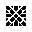

In [217]:
original_watermark1_extracted

In [240]:
watermark1_extracted_bright_original.show()

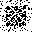

In [219]:
original_watermark2_extracted

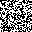

In [220]:
watermark2_extracted_bright_original

## Salt and Pepper Noise


In [223]:
noisy_image = salt_and_pepper_noise(watermarked_image)

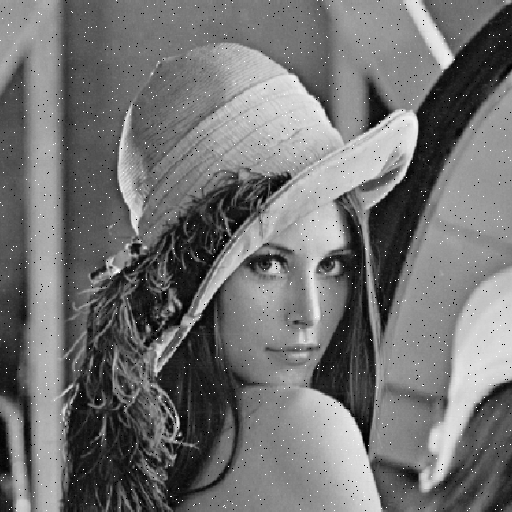

In [224]:
noisy_image

In [225]:
psnr_value_noisy = psnr(input_image, noisy_image)
psnr_value_noisy

44.875401952919304

In [226]:
ftl_noisy, _, _ ,fbr_noisy = split_image_into_four(noisy_image)

In [227]:
watermark1_extracted_noisy = extract_watermark_from_d_matrix(ftl_noisy)
watermark1_extracted_noisy = Image.fromarray(watermark1_extracted_noisy.astype(np.uint8)*255)
watermark1_extracted_noisy_original = unshuffle_watermark_image(watermark1_extracted_noisy, indices)

watermark2_extracted_noisy = extract_watermark_from_u_matrix(ftl_noisy)
watermark2_extracted_noisy = Image.fromarray(watermark2_extracted_noisy.astype(np.uint8)*255)
watermark2_extracted_noisy_original = unshuffle_watermark_image(watermark2_extracted_noisy, indices)

In [228]:
ber1_value_noisy = ber(watermark_image, watermark1_extracted_noisy_original)
ber1_value_noisy

0.3427734375

In [229]:
ber2_value_noisy = ber(watermark_image, watermark2_extracted_noisy_original)
ber2_value_noisy

0.50390625

In [230]:
normalized_watermark1_noisy = normalize_watermark(watermark1_extracted_noisy_original)
normalized_watermark2_noisy = normalize_watermark(watermark2_extracted_noisy_original)

In [231]:
nc1_value_noisy = nc(watermark_image, normalized_watermark1_noisy)
nc1_value_noisy

0.7485394338621664

In [232]:
nc2_value_noisy = nc(watermark_image, normalized_watermark2_noisy)
nc2_value_noisy

0.6109841245839551

In [244]:
original_watermark1_extracted.show()

In [242]:
watermark1_extracted_noisy_original.show()

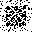

In [236]:
original_watermark2_extracted

In [243]:
watermark2_extracted_noisy_original.show()